In [1]:
import os
import glob
import time
import joblib
import truvari
import numpy as np
import joblib
import pickle
import pandas as pd
import seaborn as sb
import truvari
import matplotlib.pyplot as plt
sb.set('poster')
pd.options.display.max_columns = 999
pd.options.display.max_rows = 50

from sklearn.metrics import roc_curve, roc_auc_score

def show_values_on_bars(axs, fmt='{:.2f}', buff=0, box=True, size=15):
    """ 
        Given a barchart (seaborn or matplotlib), add values on top of bars
         c/o https://stackoverflow.com/a/51535326 
    """
    def _show_on_single_plot(ax):
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height() + buff
            value = fmt.format(p.get_height())
            t = ax.text(_x, _y, value, ha="center", size=size)
            if box:
                t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='white'))

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

def make_roc_curves(results, title_label):
    """
    """
    for tys, label in [(["DEL", "INS"], "TOT"), (["INS"], "INS"), (["DEL"], "DEL")]:
        res = results[results["svtype"].isin(tys)]
        fpr, tpr, thresholds = roc_curve(res["concordant"], res["GQ"])
        auc = roc_auc_score(res["concordant"], res["GQ"])
        accuracy = res["concordant"].mean()
        plt.plot(fpr, tpr, label="%s (%.2f%%, %.2f)" % (label, accuracy * 100, auc))
    plt.title(f"{title_label} ROC curves")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(title="SV (ACC, AUC)")
    hide = plt.show()

def summarize_perf_by_attribs(results):
    rows = []
    for vals, dat in results.groupby(["svtype", "GT_label"]):
        dat = dat.groupby(["concordant"]).count()
        tp = dat.loc[True]["REF"]
        fp = dat.loc[False]["REF"]
        rows.append([vals[0], truvari.GT(vals[1]).name, tp / (tp + fp)])
    summary = pd.DataFrame(rows, columns=["svtype", "GT", "pct_correct"])

    p = sb.barplot(data=summary, x="GT", y="pct_correct", hue="svtype")
    p.set(title="Performance by Type/GT", ylim=(0,1.1), xlabel="Label GT")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    show_values_on_bars(p, box=False)
    plt.show()
    return summary

def make_gt_heatmap(results):
    rows = np.zeros((3,3))
    for label, dat in results.groupby(["GT_label", "predict"]):
        # Some sites may be GT.NON or GT.UNK, Ignore them.
        if label[0] >= 3 or label[1] >= 3:
            continue
        cnt = len(dat)
        rows[label[0]][label[1]] = cnt
    rows = pd.DataFrame(rows, index=["REF", "HET", "HOM"], columns=["REF", "HET", "HOM"])
    pred_rows = rows / rows.sum(axis=0)
    annot_kws = {"ha": 'center',"va": 'center', "size":18}
    p = sb.heatmap(pred_rows * 100, annot=True, annot_kws=annot_kws, fmt=".1f")
    hide = p.set(title="Predicted Genotype Accuracy", xlabel="Predicted", ylabel="Label", ylim=(-0, 3))
    plt.show()
    label_rows = rows.T / rows.sum(axis=1)
    annot_kws = {"ha": 'center',"va": 'center', "size":18}
    p = sb.heatmap(label_rows.T * 100, annot=True, annot_kws=annot_kws, fmt=".1f")
    hide = p.set(title="Labeled Genotype Accuracy", xlabel="Predicted", ylabel="Label", ylim=(-0, 3))
    plt.show()
    

def performance_table(counts):
    """
    Concordance or Presence column
    """
    tp = counts["TP"] if "TP" in counts else 0
    fp = counts["FP"] if "FP" in counts else 0
    tn = counts["TN"] if "TN" in counts else 0
    fn = counts["FN"] if "FN" in counts else 0
    try:
        tpr = tp / (tp + fn)
    except Exception:
        tpr = None
    try:
        tnr = tn / (tn + fp)
    except Exception:
        tnr = None
    try:
        ppv = tp / (tp + fp)
    except Exception:
        ppv = None
    try:
        npv = tn / (tn + fn)
    except Exception:
        npv = None
    try:
        fpr = fp / (fp + tn)
    except Exception:
        fpr = None
    try:
        acc = (tp + tn) / counts.sum()
    except Exception:
        acc = None
    try:
        fdr = fp / (fp + tp)
    except Exception:
        fdr = None
    f1 = 2 * ((ppv * tpr) / (ppv + tpr))
    ba = (tpr + tnr) / 2
    return pd.DataFrame([{"TPR": tpr, "FPR": fpr, "FDR": fdr, 
                          "ACC": acc, "TNR": tnr, "PPV": ppv, 
                          "NPV": npv, "F1": f1, "BA":ba}])

def accuracy_report(results):
    print(len(results), "SVs to report")
    print("Overall Accuracy:", results["concordant"].mean())
    print(results.groupby(["GT_label"])["concordant"].mean())

    make_roc_curves(results, "Overall")
    make_roc_curves(results[results["GT_label"] != 0], "Present SVs")
    make_roc_curves(results[results["GT_label"] == 0], "Reference SVs")

    summary = summarize_perf_by_attribs(results)
    print(summary)

    make_gt_heatmap(results)
    print("Presence Performance Overall")
    print(performance_table(results))
    
state_type = pd.CategoricalDtype(["TP", "TN", "FP", "FN", "UK"], ordered=True)

def concordance_compare(base, comp):
    ret = np.array(["UK"] * len(base))
    b_ref = base == "REF"
    b_het = base == "HET"
    b_hom = base == "HOM"
    c_ref = comp == "REF"
    c_het = comp == "HET"
    c_hom = comp == "HOM"
    ret[(b_ref) & (c_ref)] = "TN"
    ret[(b_ref) & (~c_ref)] = "FP"
    ret[(b_het)] = "FP" # Assumed Default
    ret[(b_het) & (c_het)] = "TP"
    ret[(b_het) & (c_ref)] = "FN"
    ret[(b_hom)] = "TP" # Assumed Default
    ret[(b_hom) & (c_ref)] = "FN"
    ret[(b_hom) & (c_het)] = "FP"    
    return pd.Series(ret, dtype=state_type)

def presence_compare(base, comp):
    ret = np.array(["UK"] * len(base))
    bref = base == "REF"
    cref = comp == "REF"
    ret[(bref) & (cref)] = "TN"
    ret[(bref) & (~cref)] = "FP"
    ret[(~bref) & (cref)] = "FN"
    ret[(~bref) & (~cref)] = "TP"
    return pd.Series(ret, dtype=state_type)

In [2]:
data = joblib.load("raw_gt_data.jl")

FileNotFoundError: [Errno 2] No such file or directory: 'raw_gt_data.jl'

In [3]:
data["hasNeigh"] = data["NumNeighbors"] != 0

/var/folders/jv/tx_f68p54vv6wf2ylmpjnwkr0000gn/T/ipykernel_26648/4047116114.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data["hasNeigh"] = data["NumNeighbors"] != 0


In [53]:
unique, counts = np.unique(data[(data["reference"] == 'grch38') & (data["program"] == "paragraph")][[_ for _ in data.columns if _.endswith("_GT")]].values.reshape(1, 7046712), return_counts=True)


,GT,total
0,HET,"695,351"
1,HOM,"244,534"
2,REF,"6,106,827"


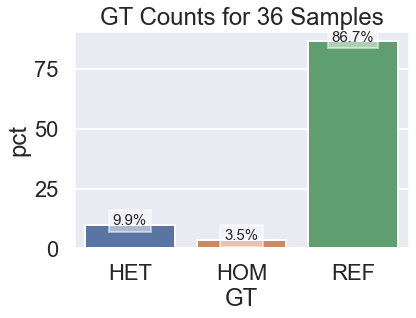

In [54]:
qview = pd.DataFrame(np.asarray((unique, counts)).T, columns=["GT", "Count"])
qview["pct"] = qview["Count"] / qview["Count"].sum() * 100
p = sb.barplot(data=qview, x="GT", y="pct")
p.set(title="GT Counts for 36 Samples")
show_values_on_bars(p, fmt="{:.1f}%")
qview["total"] = qview["Count"].apply(lambda x: "{:,d}".format(x))
qview[["GT", "total"]]

In [5]:
list(data.columns)

['id',
 'svtype',
 'svlen',
 'szbin',
 'qual',
 'filter',
 'is_pass',
 'SVTYPE',
 'SVLEN',
 'NumCollapsed',
 'CollapseId',
 'AN',
 'AC',
 'NS',
 'AC_Hom',
 'AC_Het',
 'AC_Hemi',
 'AF',
 'MAF',
 'HWE',
 'ExcHet',
 'SimpleRepeatDiff',
 'SREP',
 'NumNeighbors',
 'NeighId',
 'HG00096_GT',
 'HG00171_GT',
 'HG02587_GT',
 'NA20847_GT',
 'HG03486_GT',
 'HG03065_GT',
 'NA20509_GT',
 'HG00512_GT',
 'HG02818_GT',
 'HG03371_GT',
 'HG03009_GT',
 'NA12329_GT',
 'NA19983_GT',
 'NA19239_GT',
 'HG01114_GT',
 'NA18534_GT',
 'HG00864_GT',
 'HG00514_GT',
 'HG00731_GT',
 'NA18939_GT',
 'HG03125_GT',
 'NA19240_GT',
 'HG03732_GT',
 'HG02492_GT',
 'NA19238_GT',
 'NA19650_GT',
 'HG01505_GT',
 'HG02011_GT',
 'HG00513_GT',
 'HG01596_GT',
 'HG03683_GT',
 'HG00732_GT',
 'NA24385_GT',
 'HG00733_GT',
 'NA12878_GT',
 'PGP1_GT',
 'HG00096_GT_cmp',
 'HG00171_GT_cmp',
 'HG00512_GT_cmp',
 'HG00513_GT_cmp',
 'HG00514_GT_cmp',
 'HG00731_GT_cmp',
 'HG00732_GT_cmp',
 'HG00733_GT_cmp',
 'HG00864_GT_cmp',
 'HG01114_GT_cmp',
 '

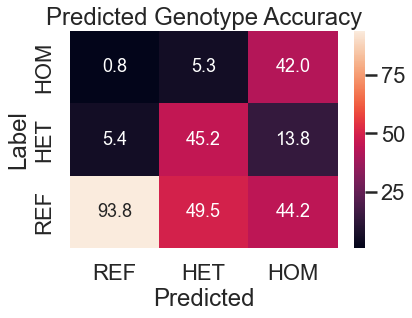

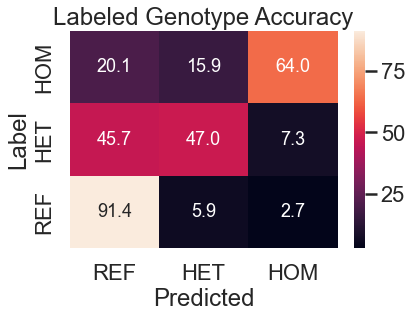

In [41]:
samples = [_ for _ in data.columns if _.endswith("_GT_cmp")]
view = data[(data["program"] == "biograph") & (data["reference"] == "grch38")]        
rows = np.zeros((3,3))
lookup = {"REF": 0, "HET": 1, "HOM": 2, "UNK":3, "NON":4}
for i in samples:
    for label, dat in view.groupby([i[:-len("_cmp")], i]):
        # Some sites may be GT.NON or GT.UNK, Ignore them.
        labelB = lookup[label[0]]
        labelC = lookup[label[1]]
        if labelB >= 3 or labelC >= 3:
            continue
        rows[labelB][labelC] += len(dat)

rows = pd.DataFrame(rows, index=["REF", "HET", "HOM"], columns=["REF", "HET", "HOM"])
rows
pred_rows = rows / rows.sum(axis=0)
annot_kws = {"ha": 'center',"va": 'center', "size":18}
p = sb.heatmap(pred_rows * 100, annot=True, annot_kws=annot_kws, fmt=".1f")
hide = p.set(title="Predicted Genotype Accuracy", xlabel="Predicted", ylabel="Label", ylim=(-0, 3))
plt.show()
label_rows = rows.T / rows.sum(axis=1)
annot_kws = {"ha": 'center',"va": 'center', "size":18}
p = sb.heatmap(label_rows.T * 100, annot=True, annot_kws=annot_kws, fmt=".1f")
hide = p.set(title="Labeled Genotype Accuracy", xlabel="Predicted", ylabel="Label", ylim=(-0, 3))
plt.show()

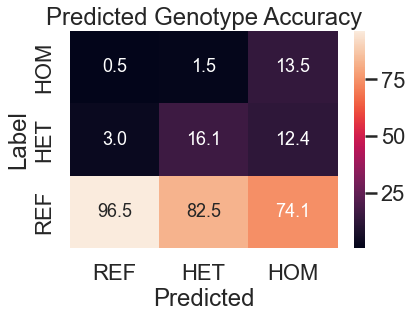

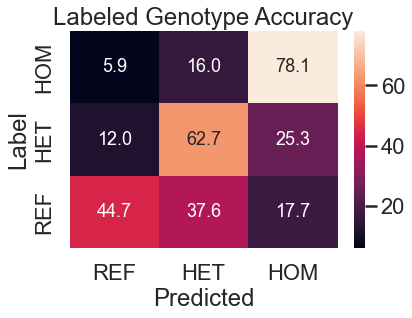

In [42]:
samples = [_ for _ in data.columns if _.endswith("_GT_cmp")]
view = data[(data["program"] == "paragraph") & (data["reference"] == "grch38")]        
rows = np.zeros((3,3))
lookup = {"REF": 0, "HET": 1, "HOM": 2, "UNK":3, "NON":4}
for i in samples:
    for label, dat in view.groupby([i[:-len("_cmp")], i]):
        # Some sites may be GT.NON or GT.UNK, Ignore them.
        labelB = lookup[label[0]]
        labelC = lookup[label[1]]
        if labelB >= 3 or labelC >= 3:
            continue
        rows[labelB][labelC] += len(dat)

rows = pd.DataFrame(rows, index=["REF", "HET", "HOM"], columns=["REF", "HET", "HOM"])
rows
pred_rows = rows / rows.sum(axis=0)
annot_kws = {"ha": 'center',"va": 'center', "size":18}
p = sb.heatmap(pred_rows * 100, annot=True, annot_kws=annot_kws, fmt=".1f")
hide = p.set(title="Predicted Genotype Accuracy", xlabel="Predicted", ylabel="Label", ylim=(-0, 3))
plt.show()
label_rows = rows.T / rows.sum(axis=1)
annot_kws = {"ha": 'center',"va": 'center', "size":18}
p = sb.heatmap(label_rows.T * 100, annot=True, annot_kws=annot_kws, fmt=".1f")
hide = p.set(title="Labeled Genotype Accuracy", xlabel="Predicted", ylabel="Label", ylim=(-0, 3))
plt.show()

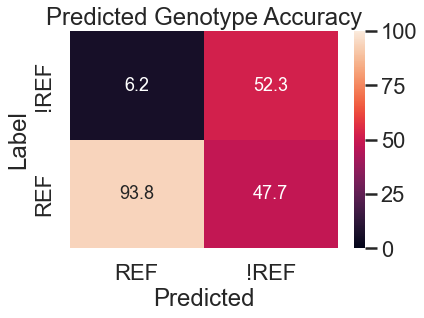

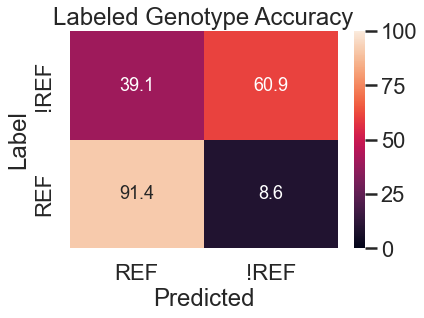

In [49]:
samples = [_ for _ in data.columns if _.endswith("_GT_cmp")]
view = data[(data["program"] == "biograph") & (data["reference"] == "grch38")]        
rows = np.zeros((2,2))
lookup = {"REF": 0, "HET": 1, "HOM": 1, "UNK":3, "NON":4}
for i in samples:
    for label, dat in view.groupby([i[:-len("_cmp")], i]):
        # Some sites may be GT.NON or GT.UNK, Ignore them.
        labelB = lookup[label[0]]
        labelC = lookup[label[1]]
        if labelB >= 3 or labelC >= 3:
            continue
        rows[labelB][labelC] += len(dat)

rows = pd.DataFrame(rows, index=["REF", "!REF"], columns=["REF", "!REF"])
rows
pred_rows = rows / rows.sum(axis=0)
annot_kws = {"ha": 'center',"va": 'center', "size":18}
p = sb.heatmap(pred_rows * 100, annot=True, annot_kws=annot_kws, fmt=".1f", vmin=0, vmax=100)
hide = p.set(title="Predicted Genotype Accuracy", xlabel="Predicted", ylabel="Label", ylim=(-0, 2))
plt.show()
label_rows = rows.T / rows.sum(axis=1)
annot_kws = {"ha": 'center',"va": 'center', "size":18}
p = sb.heatmap(label_rows.T * 100, annot=True, annot_kws=annot_kws, fmt=".1f", vmin=0, vmax=100)
hide = p.set(title="Labeled Genotype Accuracy", xlabel="Predicted", ylabel="Label", ylim=(-0, 2))
plt.show()

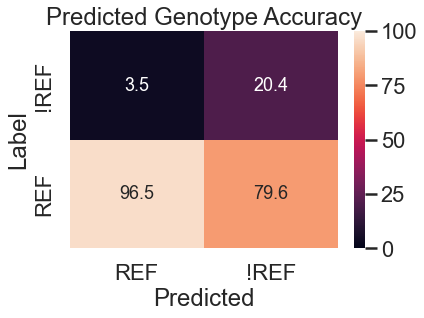

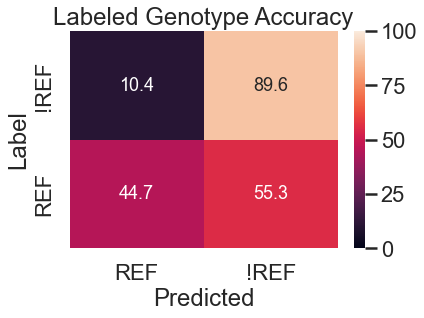

In [50]:
samples = [_ for _ in data.columns if _.endswith("_GT_cmp")]
view = data[(data["program"] == "paragraph") & (data["reference"] == "grch38")]        
rows = np.zeros((2,2))
lookup = {"REF": 0, "HET": 1, "HOM": 1, "UNK":3, "NON":4}
for i in samples:
    for label, dat in view.groupby([i[:-len("_cmp")], i]):
        # Some sites may be GT.NON or GT.UNK, Ignore them.
        labelB = lookup[label[0]]
        labelC = lookup[label[1]]
        if labelB >= 3 or labelC >= 3:
            continue
        rows[labelB][labelC] += len(dat)

rows = pd.DataFrame(rows, index=["REF", "!REF"], columns=["REF", "!REF"])
rows
pred_rows = rows / rows.sum(axis=0)
annot_kws = {"ha": 'center',"va": 'center', "size":18}
p = sb.heatmap(pred_rows * 100, annot=True, annot_kws=annot_kws, fmt=".1f", vmin=0, vmax=100)
hide = p.set(title="Predicted Genotype Accuracy", xlabel="Predicted", ylabel="Label", ylim=(-0, 2))
plt.show()
label_rows = rows.T / rows.sum(axis=1)
annot_kws = {"ha": 'center',"va": 'center', "size":18}
p = sb.heatmap(label_rows.T * 100, annot=True, annot_kws=annot_kws, fmt=".1f", vmin=0, vmax=100)
hide = p.set(title="Labeled Genotype Accuracy", xlabel="Predicted", ylabel="Label", ylim=(-0, 2))
plt.show()

In [ ]:
samples = [_ for _ in data.columns if _.endswith("_GT_cmp")]
view = data[(data["program"] == "biograph") & (data["reference"] == "grch38")]        
rows = np.zeros((2,2))
lookup = {"REF": 0, "HET": 1, "HOM": 1, "UNK":3, "NON":4}
for i in samples:
    for label, dat in view.groupby([i[:-len("_cmp")], i]):
        # Some sites may be GT.NON or GT.UNK, Ignore them.
        labelB = lookup[label[0]]
        labelC = lookup[label[1]]
        if labelB >= 3 or labelC >= 3:
            continue
        rows[labelB][labelC] += len(dat)

rows = pd.DataFrame(rows, index=["REF", "PRE"], columns=["REF", "PRE"])
rows
pred_rows = rows / rows.sum(axis=0)
annot_kws = {"ha": 'center',"va": 'center', "size":18}
p = sb.heatmap(pred_rows * 100, annot=True, annot_kws=annot_kws, fmt=".1f")
hide = p.set(title="Predicted Genotype Accuracy", xlabel="Predicted", ylabel="Label", ylim=(-0, 3))
plt.show()
label_rows = rows.T / rows.sum(axis=1)
annot_kws = {"ha": 'center',"va": 'center', "size":18}
p = sb.heatmap(label_rows.T * 100, annot=True, annot_kws=annot_kws, fmt=".1f")
hide = p.set(title="Labeled Genotype Accuracy", xlabel="Predicted", ylabel="Label", ylim=(-0, 3))
plt.show()

In [ ]:
rows = []
for grp, m_dat in data.groupby(["program", "svtype", "reference", "hasNeigh"]):
    prog, svtype, reference, neigh = grp
    view = pd.melt(m_dat[[x for x in data.columns if x.endswith("_presence")]])
    view = performance_table(view["value"].value_counts())
    view["program"] = prog
    view["svtype"] = svtype
    view["reference"] = reference
    view["hasNeigh"] = neigh
    view["comparison"] = "presence"
    rows.append(view)
    
    view = pd.melt(m_dat[[x for x in data.columns if x.endswith("_concordance")]])
    view = performance_table(view["value"].value_counts())
    view["program"] = prog
    view["svtype"] = svtype
    view["reference"] = reference
    view["hasNeigh"] = neigh
    view["comparison"] = "concordance"
    rows.append(view)
    
summary = pd.concat(rows)

In [105]:
rows = []
for grp, m_dat in data.groupby(["program", "svtype", "reference", "hasNeigh"]):
    prog, svtype, reference, neigh = grp
    view = pd.melt(m_dat[[x for x in data.columns if x.endswith("_presence")]])
    view = performance_table(view["value"].value_counts())
    view["program"] = prog
    view["svtype"] = svtype
    view["reference"] = reference
    view["hasNeigh"] = neigh
    view["comparison"] = "presence"
    rows.append(view)
    
    view = pd.melt(m_dat[[x for x in data.columns if x.endswith("_concordance")]])
    view = performance_table(view["value"].value_counts())
    view["program"] = prog
    view["svtype"] = svtype
    view["reference"] = reference
    view["hasNeigh"] = neigh
    view["comparison"] = "concordance"
    rows.append(view)
    
summary = pd.concat(rows)

In [133]:
summary.sort_values(['comparison', 'hasNeigh']).head()

,TPR,FPR,FDR,ACC,TNR,PPV,NPV,F1,BA,program,svtype,reference,hasNeigh,comparison,SV Neigh,Neigh SV
0,0.767454,0.103294,0.398694,0.874896,0.896706,0.601306,0.949990,0.674296,0.832080,biograph,DEL,chm13,False,concordance,DEL False,False DEL
0,0.903512,0.091454,0.270846,0.907468,0.908546,0.729154,0.971874,0.807023,0.906029,biograph,DEL,grch38,False,concordance,DEL False,False DEL
0,0.811305,0.106282,0.453706,0.882490,0.893718,0.546294,0.967770,0.652933,0.852511,biograph,INS,chm13,False,concordance,INS False,False INS
0,0.902848,0.096491,0.316154,0.903385,0.903509,0.683846,0.975746,0.778233,0.903179,biograph,INS,grch38,False,concordance,INS False,False INS
0,0.920308,0.083819,0.250086,0.917066,0.916181,0.749914,0.976796,0.826419,0.918245,paragraph,DEL,grch38,False,concordance,DEL False,False DEL


In [110]:
summary['SV Neigh'] = summary[["svtype", "hasNeigh"]].apply(func=lambda x: f"{x.loc['svtype']} {x.loc['hasNeigh']}", axis=1)

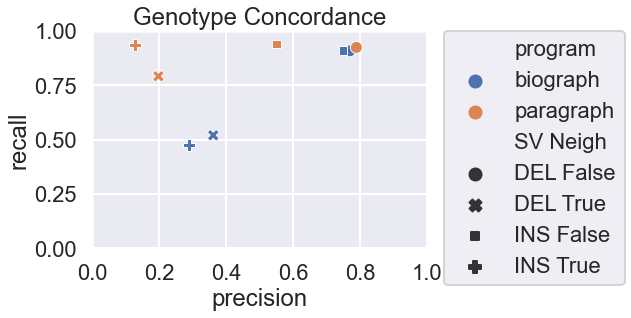

In [137]:
p = sb.scatterplot(data=summary[(summary["comparison"] == "presence") & (summary["reference"] == 'grch38')], 
                   y="TPR", x="PPV", hue="program", style="SV Neigh")
p.set(title="Genotype Concordance", ylim=(0,1), xlim=(0,1), ylabel="recall", xlabel="precision")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [225]:
subset = data[(data["program"] == "biograph") & (data["reference"] == "grch38")]
(subset.groupby(["SREP", "hasNeigh"]).size().unstack() / len(subset) * 100).style.format("{:.1f}%")

hasNeigh,False,True
SREP,,
False,12.2%,5.2%
True,8.0%,74.7%


In [217]:
m_dat = data[(data["program"] == "paragraph") & (data["hasNeigh"])]
view = pd.melt(m_dat[[x for x in data.columns if x.endswith("_presence")]])
performance_table(view["value"].value_counts())

,TPR,FPR,FDR,ACC,TNR,PPV,NPV,F1,BA
0,0.885721,0.681271,0.856832,0.383301,0.318729,0.143168,0.95595,0.246492,0.602225


In [218]:
m_dat = data[(data["program"] == "biograph") & (data["hasNeigh"])]
view = pd.melt(m_dat[[x for x in data.columns if x.endswith("_presence")]])
performance_table(view["value"].value_counts())

,TPR,FPR,FDR,ACC,TNR,PPV,NPV,F1,BA
0,0.426997,0.132845,0.724996,0.820694,0.867155,0.275004,0.927661,0.334546,0.647076


In [166]:
data.groupby(["reference"])["program"].value_counts()

reference  program  
chm13      biograph     212699
grch38     biograph     195742
           paragraph    195742
Name: program, dtype: int64

array([     0.,  25000.,  50000.,  75000., 100000., 125000.])

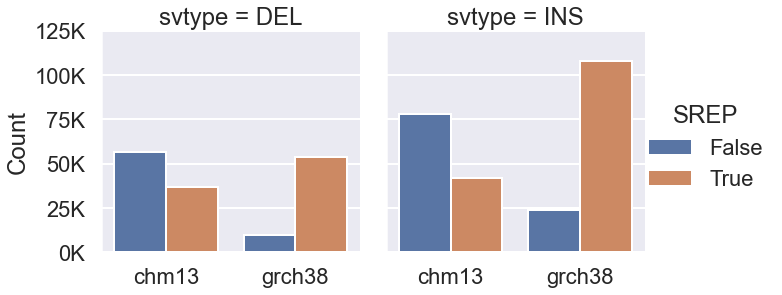

In [214]:
view = data[data["program"] == "biograph"].groupby(["reference", "svtype"])["SREP"].value_counts()
view.name = "Count"
view = view.reset_index()
p = sb.catplot(data=view, kind="bar", col="svtype", x="reference", y="Count", hue="SREP", col_order=["DEL", "INS"])
ylabels = ['{:,.0f}'.format(x) + 'K' for x in [_ for _ in p.axes.flat ][0].get_yticks()/1000]
p.set_yticklabels(ylabels)
p.set(xlabel="")
#p.fig.subplots_adjust(bottom=0.1) # adjust the Figure in rp
#p.fig.suptitle('ONE TITLE FOR ALL')


In [149]:
performance_table(data[data["reference"] == "chm13"]["HG03065_concordance"].value_counts())

,TPR,FPR,FDR,ACC,TNR,PPV,NPV,F1,BA
0,0.452042,0.114914,0.654478,0.833845,0.885086,0.345522,0.923286,0.391669,0.668564


In [229]:
rows = []
for grp, m_dat in data.groupby(["reference", "program", "hasNeigh"]):
    reference, prog, neigh = grp    
    view = pd.melt(m_dat[[x for x in data.columns if x.endswith("_concordance")]])
    view = performance_table(view["value"].value_counts())
    view["program"] = prog
    view["reference"] = reference
    view["hasNeigh"] = neigh
    view["comparison"] = "concordance"
    rows.append(view)
    
nview = pd.concat(rows)

In [254]:
#((nview[nview["reference"] == 'grch38'].groupby(["program", "hasNeigh"]).mean()["ACC"].unstack()) * 100).style.format("{:.1f%}")
s = (nview[nview["reference"] == 'grch38'].groupby(["program", "hasNeigh"]).mean()["ACC"].unstack()) * 100
s.style.format("{:.1f}%")

hasNeigh,False,True
program,,
biograph,90.5%,80.2%
paragraph,85.8%,34.5%


In [255]:
#((nview[nview["reference"] == 'grch38'].groupby(["program", "hasNeigh"]).mean()["ACC"].unstack()) * 100).style.format("{:.1f%}")
s = (nview[nview["reference"] == 'grch38'].groupby(["program", "hasNeigh"]).mean()["BA"].unstack()) * 100
s.style.format("{:.1f}%")

hasNeigh,False,True
program,,
biograph,90.4%,62.3%
paragraph,88.4%,56.6%


In [ ]:
#((nview[nview["reference"] == 'grch38'].groupby(["program", "hasNeigh"]).mean()["ACC"].unstack()) * 100).style.format("{:.1f%}")
s = (nview[nview["reference"] == 'grch38'].groupby(["program"]).mean()["BA"].unstack()) * 100
s.style.format("{:.1f}%")

In [143]:
metadata = pd.read_csv("../metadata/sample_metadata.txt", sep="\t")
metadata

,Individual,FamilyId,TrioState,Sex,Population code,Population name,Superpopulation code,Superpopulation name,AltIDs
0,NA12878,RM8398,child,female,CEU,Utah Residents (CEPH) with Northern and Wester...,EUR,European Ancestry,"NA12878,ERR3988823,GM19240"
1,NA24385,RM8392,child,male,ASH,Ashkenazi,EUR,European Ancestry,"HG002,GM24385,huAA53E0"
2,HG003,RM8392,father,male,ASH,Ashkenazi,EUR,European Ancestry,NaN
3,HG004,RM8392,mother,female,ASH,Ashkenazi,EUR,European Ancestry,NaN
4,HG005,RM8393,child,male,CHS,Southern Han Chinese,EAS,East Asian Ancestry,NaN
5,HG006,RM8393,father,male,CHS,Southern Han Chinese,EAS,East Asian Ancestry,NaN
6,HG007,RM8393,mother,female,CHS,Southern Han Chinese,EAS,East Asian Ancestry,NaN
7,NA12891,RM8398,father,male,CEU,Utah Residents (CEPH) with Northern and Wester...,EUR,European Ancestry,NaN
8,NA12892,RM8398,mother,female,CEU,Utah Residents (CEPH) with Northern and Wester...,EUR,European Ancestry,NaN
9,HG00096,HG00096,unrel,male,GBR,British,EUR,European Ancestry,NaN


In [ ]:
rows = []
for grp, m_dat in data.groupby(["program", "svtype", "reference", "hasNeigh", 'sample']):
    prog, svtype, reference, neigh = grp
    view = pd.melt(m_dat[[x for x in data.columns if x.endswith("_presence")]])
    view = performance_table(view["value"].value_counts())
    view["program"] = prog
    view["svtype"] = svtype
    view["reference"] = reference
    view["hasNeigh"] = neigh
    view["comparison"] = "presence"
    rows.append(view)
    
    view = pd.melt(m_dat[[x for x in data.columns if x.endswith("_concordance")]])
    view = performance_table(view["value"].value_counts())
    view["program"] = prog
    view["svtype"] = svtype
    view["reference"] = reference
    view["hasNeigh"] = neigh
    view["comparison"] = "concordance"
    rows.append(view)
    
summary = pd.concat(rows)

# Check the overall accuracy

In [193]:
print("Overall:")
print("BioGraph - %.2f%%" % (bg_full["GT_exact_state"].mean() * 100))
print("Paragraph - %.2f%%" % (par_full[par_full["FT"] == "PASS"]["GT_exact_state"].mean() * 100))
view = pd.concat([bg_full.groupby(["svtype_base", "GT_base"])["GT_exact_state"].mean(),
                  par_full.groupby(["svtype_base", "GT_base"])["GT_exact_state"].mean()],
                axis=1)
view.columns = ["BioGraph", "Paragraph"]
view.loc[["DEL", "INS"]]

Overall:
BioGraph - 85.56%
Paragraph - 59.46%


BioGraph  Paragraph
svtype_base GT_base                     
DEL         HET      0.448358   0.687148
            HOM      0.461365   0.700112
            REF      0.952071   0.634862
INS         HET      0.394614   0.564093
            HOM      0.540371   0.785847
            REF      0.898908   0.347035

In [194]:
print("BioGraph")
make_summary(bg_full)
print("\nParagraph")
make_summary(par_full)

BioGraph
Overall Performance
Exact: 0.8555547044555087
Presence: 0.8700778756542832
Count: 0.9146763692072003
Performance by SVTYPE
  svtype     Exact  Presence     Count
0    DEL  0.877988  0.892875  0.931685
1    INS  0.844811  0.859160  0.906531
2    DUP       NaN       NaN       NaN
3    INV       NaN       NaN       NaN
4    NON       NaN       NaN       NaN
5    UNK       NaN       NaN       NaN
Performance by Genotype
  BaseGT     Exact  Presence     Count
0    HET  0.414853  0.475404  0.707426
1    HOM  0.510178  0.762758  0.636468
2    REF  0.915704  0.915704  0.947687

Paragraph
Overall Performance
Exact: 0.46497787350895015
Presence: 0.49599069003006346
Count: 0.6481530632557332
Performance by SVTYPE
  svtype     Exact  Presence     Count
0    DEL  0.643168   0.66401  0.787375
1    INS  0.379573   0.41546  0.581425
2    DUP       NaN       NaN       NaN
3    INV       NaN       NaN       NaN
4    NON       NaN       NaN       NaN
5    UNK       NaN       NaN       NaN
Perfor

In [195]:
print("Filtring Paragraph")
par_pass = par_full[par_full["FT"] == "PASS"] 
print("Leaves %.2f%%" % ((len(par_pass) / len(par_full)) * 100))
make_summary(par_pass)

Filtring Paragraph
Leaves 61.33%
Overall Performance
Exact: 0.5945640052595662
Presence: 0.6211281436727085
Count: 0.7396223431700537
Performance by SVTYPE
  svtype     Exact  Presence     Count
0    DEL  0.724717  0.740065  0.837138
1    INS  0.519073  0.552143  0.683061
2    DUP       NaN       NaN       NaN
3    INV       NaN       NaN       NaN
4    NON       NaN       NaN       NaN
5    UNK       NaN       NaN       NaN
Performance by Genotype
  BaseGT     Exact  Presence     Count
0    HET  0.660848  0.887772  0.830424
1    HOM  0.840099  0.957881  0.900991
2    REF  0.574866  0.574866  0.721503


# Filtering
Let's Look at possibilities of filtering 'less confident' genotypes 

The first source of 'errors' is NumNeighbors, which counts how many other SVs - of any type - are within 1kbp of a call.

We'll progressively filter the calls by MaxNumNeighbors (e.g. performance for calls with <=Max)

We're measuring accuracy using the "Paragraph Compare", which assigns a state (TP/FP/FN/TN) based on the presence/absence of the call in from the LRA-SVs and how BioGraph genotyped it.

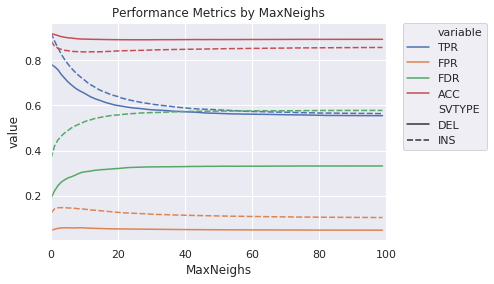

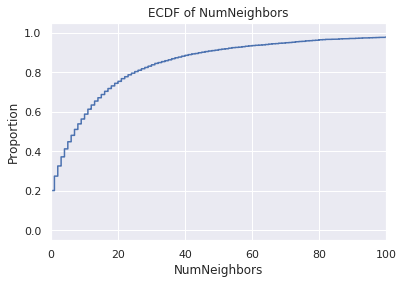

Cumulative Sum:
0      0.201603
1      0.274684
2      0.326026
3      0.372087
4      0.412460
         ...   
157    0.999980
165    0.999985
143    0.999990
173    0.999995
234    1.000000
Name: NumNeighbors, Length: 186, dtype: float64


In [196]:
filter_figures(bg_full, "NumNeighbors", "MaxNeighs", 100, "lt")

As we have more neighbors, BioGraph's performance drops up to ~10. To balance the number of calls kept and the performance, we will consider removing calls with >= 10 Neighbors. This removes 5.3% of calls

Another metric to possibly filter on is the "PLConfidence", this is simply the difference in the second smallest PL from the smallest. For example, if the PL is `[0, 4, 99]`, REF is most confident (0), but HET is also fairly confident (4). The PLConfidence would be 4. If there were a more confidence site with PL `[99, 0, 90]`, the bayesGT has 90 PLConfidence in the genotype.

We will look at filtering for calls having at least MinPLConfidence confidence score.

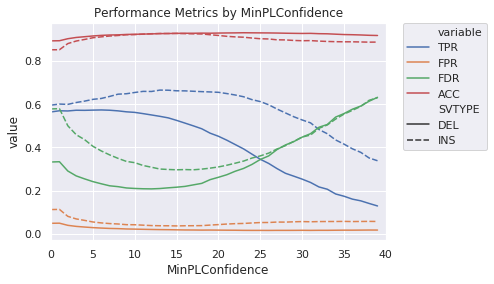

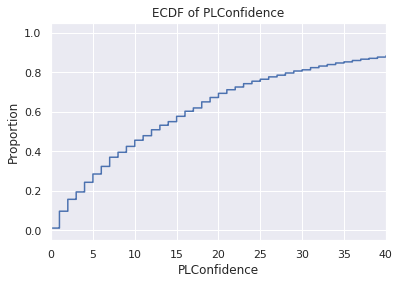

Cumulative Sum:
1.0     0.078790
2.0     0.134278
4.0     0.179415
7.0     0.222249
5.0     0.260881
          ...   
77.0    0.919168
80.0    0.920092
66.0    0.921006
71.0    0.921910
74.0    0.922783
Name: PLConfidence, Length: 98, dtype: float64


In [197]:
filter_figures(bg_full, "PLConfidence", "MinPLConfidence", 40, "gt")

The Performance seems to peak at somewhere around 10. However, if we removed all calls with PLConfidence <= 10, we'd remove approximately 47% of calls, so we'll settle for a MinPlConfidence of 5.

Let's see what these two filters (PLConfidence >= 5, NumNeighbors <= 10) do to the performance.

In [204]:
keep = (bg_full["NumNeighbors"] == 0) # (bg_full["PLConfidence"].between(2,50))# & 
print("Leaves %.2f%% of calls" % (len(keep[keep]) / len(keep) * 100))
make_summary(bg_full[keep & ~bg_full["isREF"]])
print()
make_summary(bg_full)

Leaves 20.16% of calls
Overall Performance
Exact: 0.7584247901872175
Presence: 0.8564234990316333
Count: 0.8622336991607489
Performance by SVTYPE
  svtype     Exact  Presence     Count
0    DEL  0.674548  0.781363  0.809458
1    INS  0.831084  0.921446  0.907952
2    DUP       NaN       NaN       NaN
3    INV       NaN       NaN       NaN
4    NON       NaN       NaN       NaN
5    UNK       NaN       NaN       NaN
Performance by Genotype
  BaseGT     Exact  Presence     Count
0    HET  0.770053  0.810829  0.885027
1    HOM  0.742401  0.919251  0.830826

Overall Performance
Exact: 0.8555547044555087
Presence: 0.8700778756542832
Count: 0.9146763692072003
Performance by SVTYPE
  svtype     Exact  Presence     Count
0    DEL  0.877988  0.892875  0.931685
1    INS  0.844811  0.859160  0.906531
2    DUP       NaN       NaN       NaN
3    INV       NaN       NaN       NaN
4    NON       NaN       NaN       NaN
5    UNK       NaN       NaN       NaN
Performance by Genotype
  BaseGT     Exact 

Comparing pre/post filtering numbers, we see that by removing 25.5% of SVs, we can boost our Exact comparison performance by ~4p.p. and our Presence comparison performance by about 5p.p.

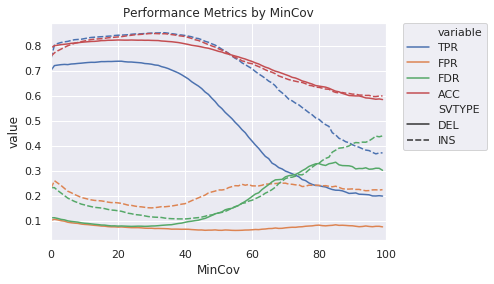

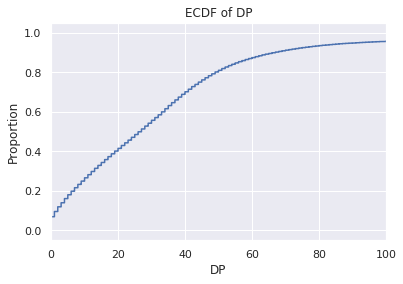

Cumulative Sum:
0       0.069338
1       0.095650
2       0.119460
4       0.140584
3       0.161010
          ...   
4339    0.999918
369     0.999938
401     0.999959
529     0.999979
4094    1.000000
Name: DP, Length: 711, dtype: float64


In [18]:
#print(state_performance(full["par_cmp"].value_counts()))
filter_figures(full, "DP", "MinCov", 100, "gt")

In [160]:
keep = bg_full[bg_full["DP"] >= 5]
print("Leaves %.2f%% of calls" % (len(keep) / len(bg_full) * 100))
make_summary(keep)

Leaves 83.35% of calls
Overall Performance
Exact: 0.8676273273659639
Presence: 0.8820556178432922
Performance by SVTYPE
  svtype     Exact  Presence
0    DEL  0.882832  0.897873
1    INS  0.859041  0.873123
2    DUP       NaN       NaN
3    INV       NaN       NaN
4    NON       NaN       NaN
5    UNK       NaN       NaN
Performance by Genotype
  BaseGT     Exact  Presence
0    HET  0.455689  0.501149
1    HOM  0.542122  0.806270
2    REF  0.927600  0.927600


In [161]:
make_summary(bg_full[bg_full["NumNeighbors"] == 0])

Overall Performance
Exact: 0.8800121583626739
Presence: 0.8992375693406621
Performance by SVTYPE
  svtype     Exact  Presence
0    DEL  0.895692  0.917603
1    INS  0.867496  0.884577
2    DUP       NaN       NaN
3    INV       NaN       NaN
4    NON       NaN       NaN
5    UNK       NaN       NaN
Performance by Genotype
  BaseGT     Exact  Presence
0    HET  0.770053  0.810829
1    HOM  0.742401  0.919251
2    REF  0.909687  0.909687


In [162]:
make_summary(par_full[par_full["NumNeighbors"] == 0])

Overall Performance
Exact: 0.8657014857374269
Presence: 0.8815206661773267
Performance by SVTYPE
  svtype     Exact  Presence
0    DEL  0.923770  0.935002
1    INS  0.819345  0.838826
2    DUP       NaN       NaN
3    INV       NaN       NaN
4    NON       NaN       NaN
5    UNK       NaN       NaN
Performance by Genotype
  BaseGT     Exact  Presence
0    HET  0.812653  0.897750
1    HOM  0.899541  0.973966
2    REF  0.869721  0.869721


In [234]:
def lil(val):
    val["key"] = val["key"].split('.')[0]
    return val
bg_full[bg_full["NumNeighbors"] >= 10][["svlen_base", "svtype_base",  "AD_ref", "AD_alt", "minPL", "GT_base"]].iloc[100:150].reset_index().apply(lil, axis=1)


,key,svlen_base,svtype_base,AD_ref,AD_alt,minPL,GT_base
0,chr1:669386-669387,384,INS,46,0,REF,REF
1,chr1:669387-669388,154,INS,51,0,REF,REF
2,chr1:669530-669531,615,INS,81,0,REF,REF
3,chr1:669650-669651,231,INS,63,1,REF,REF
4,chr1:669650-669651,77,INS,64,0,REF,REF
5,chr1:669879-669880,6388,INS,161,0,REF,REF
6,chr1:669925-669926,313,INS,73,0,REF,REF
7,chr1:669925-669926,388,INS,72,4,REF,REF
8,chr1:875985-875986,3348,INS,7,0,REF,REF
9,chr1:875990-875991,116,INS,7,1,REF,REF
